# Evaluation of network communications

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import ipaddress
import dns.resolver
import dns.reversename
import pygeoip

## About the Datasets
There are 2 datasets:
- **data3**: contains the data of the communication in one day without any anomalous behavior;
- **test3**: contains the data of the communication in one day with anomalous behavior;

Each dataframe contains the following columns:
- `index`: the index of the row
- `timestamp`: the timestamp of the event
- `src_ip`: the source IP address
- `dst_ip`: the destination IP address
- `proto`: the protocol used
- `port`: the port used
- `up_bytes`: the number of bytes uploaded by the source
- `down_bytes`: the number of bytes downloaded by the source

In [2]:
non_anomalous_df = pd.read_parquet('datasets/dataset3/data3.parquet')
non_anomalous_df.head()

,timestamp,src_ip,dst_ip,proto,port,up_bytes,down_bytes
index,,,,,,,
779943,957860,192.168.103.11,142.250.200.99,tcp,443,22243,228517
779944,957930,192.168.103.11,193.126.240.146,tcp,443,34885,199897
779945,958055,192.168.103.11,193.126.240.146,tcp,443,25383,216980
779946,958066,192.168.103.11,193.126.240.146,tcp,443,19162,99479
779947,958171,192.168.103.11,193.126.240.146,tcp,443,7247,60469


In [3]:
anomalous_df = pd.read_parquet('datasets/dataset3/test3.parquet')
anomalous_df.head()

,timestamp,src_ip,dst_ip,proto,port,up_bytes,down_bytes
index,,,,,,,
174163,1488996,192.168.103.17,192.168.103.228,udp,53,210,611
174164,1489002,192.168.103.17,192.168.103.228,udp,53,204,580
174165,1489088,192.168.103.17,142.250.200.99,tcp,443,8967,57243
174166,1489284,192.168.103.17,142.250.200.99,tcp,443,4501,34854
174167,1489314,192.168.103.17,142.250.200.99,tcp,443,22478,178992


## Inside vs. Outside the Network

This part makes a comparison to the number of packets sent inside and outside the network.

In [4]:
def inside_outside_network(dataframe, title_prefix=''):
    internal_network = ipaddress.IPv4Network('192.168.103.0/24')
    binternal = dataframe.apply(lambda x: ipaddress.ip_address(x['dst_ip']) in internal_network, axis=1)
    bexternal = dataframe.apply(lambda x: ipaddress.ip_address(x['dst_ip']) not in internal_network, axis=1)

    return binternal, bexternal


na_internal_network_packets, na_external_network_packets = inside_outside_network(non_anomalous_df,
                                                                                  title_prefix='Non-anomalous')
print(f'Number of packets sent inside the network (Non-anomalous dataset): {na_internal_network_packets.sum()}')
print(f'Number of packets sent outside the network (Non-anomalous dataset): {na_external_network_packets.sum()}')
print(
    f'Ratio of packets sent outside the network (Non-anomalous dataset): {na_external_network_packets.sum() / len(non_anomalous_df) * 100:.2f}%')
print(
    f'Ratio of packets sent inside the network (Non-anomalous dataset): {na_internal_network_packets.sum() / len(non_anomalous_df) * 100:.2f}%')

print()

a_internal_network_packets, a_external_network_packets = inside_outside_network(anomalous_df, title_prefix='Anomalous')
print(f'Number of packets sent inside the network (Anomalous dataset): {a_internal_network_packets.sum()}')
print(f'Number of packets sent outside the network (Anomalous dataset): {a_external_network_packets.sum()}')
print(
    f'Ratio of packets sent outside the network (Anomalous dataset): {a_external_network_packets.sum() / len(anomalous_df) * 100:.2f}%')
print(
    f'Ratio of packets sent inside the network (Anomalous dataset): {a_internal_network_packets.sum() / len(anomalous_df) * 100:.2f}%')

Number of packets sent inside the network (Non-anomalous dataset): 280139
Number of packets sent outside the network (Non-anomalous dataset): 666458
Ratio of packets sent outside the network (Non-anomalous dataset): 70.41%
Ratio of packets sent inside the network (Non-anomalous dataset): 29.59%

Number of packets sent inside the network (Anomalous dataset): 359169
Number of packets sent outside the network (Anomalous dataset): 678661
Ratio of packets sent outside the network (Anomalous dataset): 65.39%
Ratio of packets sent inside the network (Anomalous dataset): 34.61%


**Warning:** A high number of packets sent inside the network could be an indicator of a possible attack, such as internal reconnaissance, data exfiltration preparation, or internal C&C communication.

## Inside the Network
Here, we analyzed the traffic flow inside the network. We will look at who communicates with whom, the protocols used, and look for any anomalies in the communication.

#### Protocols used
##### Transport Layer Protocols
The packets are divided into two protocols: TCP and UDP. As we can see in the following plot, the number of TCP packets is higher than the number of UDP packets, with almost 90% of the packets being TCP packets.

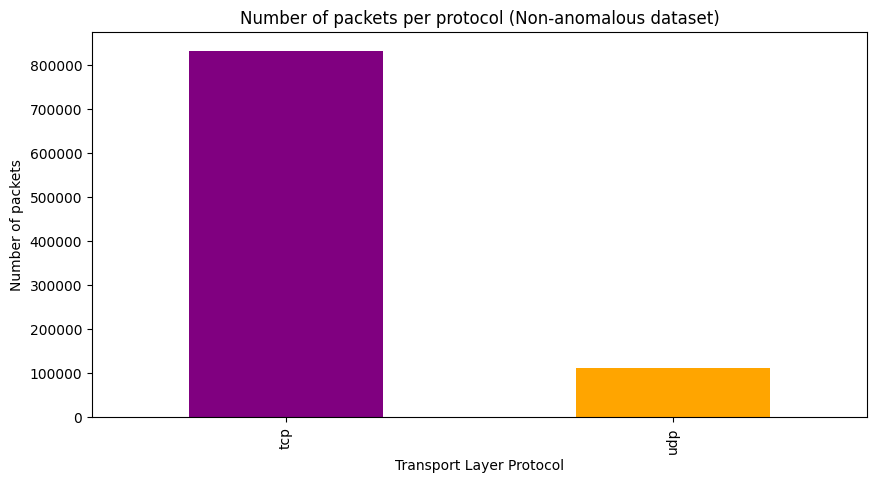

Ratio of TCP packets (Non-anomalous dataset): 88.06%
Ratio of UDP packets (Non-anomalous dataset): 11.94%


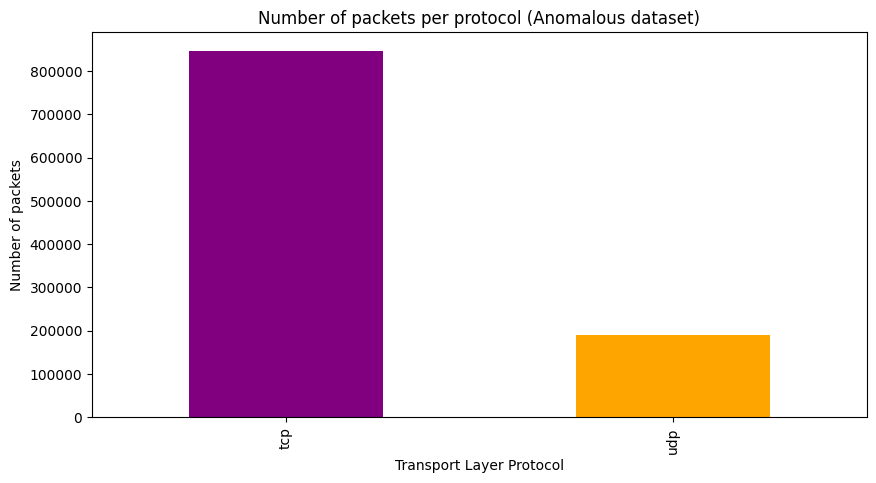

Ratio of TCP packets (Anomalous dataset): 81.69%
Ratio of UDP packets (Anomalous dataset): 18.31%


In [5]:
def transport_protocol_distribution(dataframe, title_prefix=''):
    plt.figure(figsize=(10, 5))
    # More neutral colors
    dataframe['proto'].value_counts().plot(kind='bar', color=['purple', 'orange'])
    plt.title(f'Number of packets per protocol ({title_prefix} dataset)')
    plt.xlabel('Transport Layer Protocol')
    plt.ylabel('Number of packets')
    plt.show()

    print(
        f'Ratio of TCP packets ({title_prefix} dataset): {len(dataframe[dataframe["proto"] == "tcp"]) / len(dataframe) * 100:.2f}%')
    print(
        f'Ratio of UDP packets ({title_prefix} dataset): {len(dataframe[dataframe["proto"] == "udp"]) / len(dataframe) * 100:.2f}%')


# Call the function for non-anomalous dataset
transport_protocol_distribution(non_anomalous_df, title_prefix='Non-anomalous')
transport_protocol_distribution(anomalous_df, title_prefix='Anomalous')

##### Ports Used (Application Layer Protocols)

The following plot shows the number of packets per application layer protocol. All the packets are divided into 2 protocols: HTTPS and DNS. The number of DNS packets is lower than the number of HTTPS packets, with almost 90% of the packets being HTTPS packets. 

However, the anomalous datasets show a small difference between the number of DNS and HTTPS packets, with a higher number of DNS packets (7% more than the non-anomalous dataset). This could indicate attacks like DNS flooding.

In [6]:
application_protocols = {
    '80': 'HTTP',
    '443': 'HTTPS',
    '22': 'SSH',
    '53': 'DNS',
    '21': 'FTP',
    '25': 'SMTP',
}

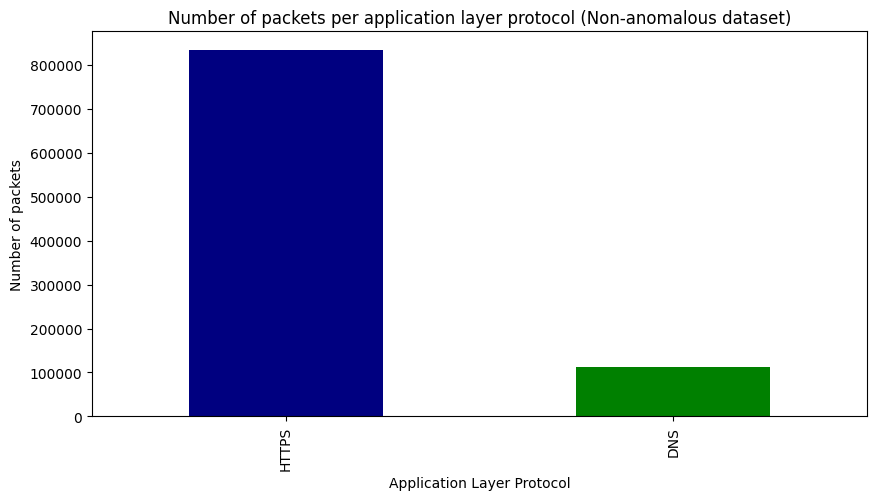

Ratio of HTTPS packets (Non-anomalous dataset): 88.06%
Ratio of DNS packets (Non-anomalous dataset): 11.94%


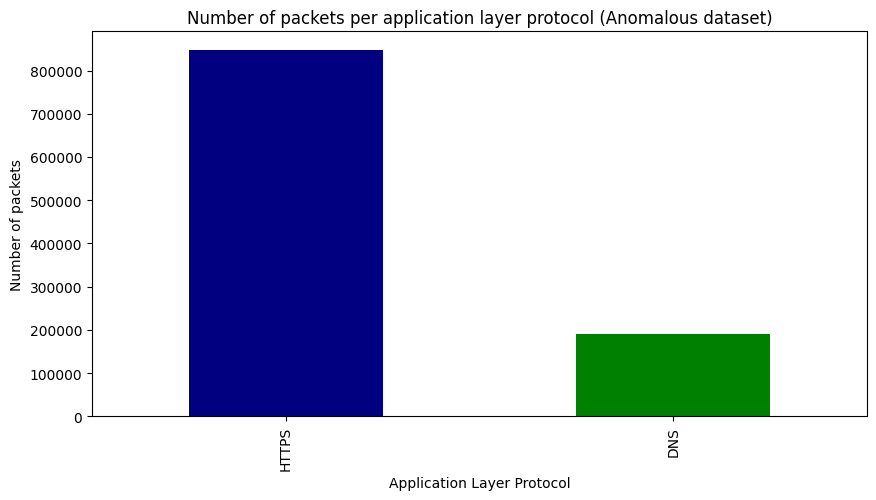

Ratio of HTTPS packets (Anomalous dataset): 81.70%
Ratio of DNS packets (Anomalous dataset): 18.30%


In [16]:
def protocol_distribution(dataframe, title_prefix=''):
    protocol_series = dataframe['port'].astype(str).map(application_protocols)

    if protocol_series.isnull().values.any():
        protocol_series = dataframe['port']

    plt.figure(figsize=(10, 5))
    protocol_series.value_counts().plot(kind='bar', color=['navy', 'green'])
    plt.title(f'Number of packets per application layer protocol ({title_prefix} dataset)')
    plt.xlabel('Application Layer Protocol')
    plt.ylabel('Number of packets')
    plt.show()

    print(
        f'Ratio of HTTPS packets ({title_prefix} dataset): {len(dataframe[dataframe["port"] == 443]) / len(dataframe) * 100:.2f}%')
    print(
        f'Ratio of DNS packets ({title_prefix} dataset): {len(dataframe[dataframe["port"] == 53]) / len(dataframe) * 100:.2f}%')


# Call the function for non-anomalous dataset
protocol_distribution(non_anomalous_df, title_prefix='Non-anomalous')

# Call the function for anomalous dataset
protocol_distribution(anomalous_df, title_prefix='Anomalous')

### Packets sent (per Source IP)

The number of packets sent by the top 100 source IPs varies between the non-anomalous and anomalous datasets. 

As we can see, two machines have sent a higher number of packets in the **anomalous dataset**:
- **192.168.103.125**
- **192.168.103.90**

Pointing out that the machines could be compromised or used for malicious purposes.


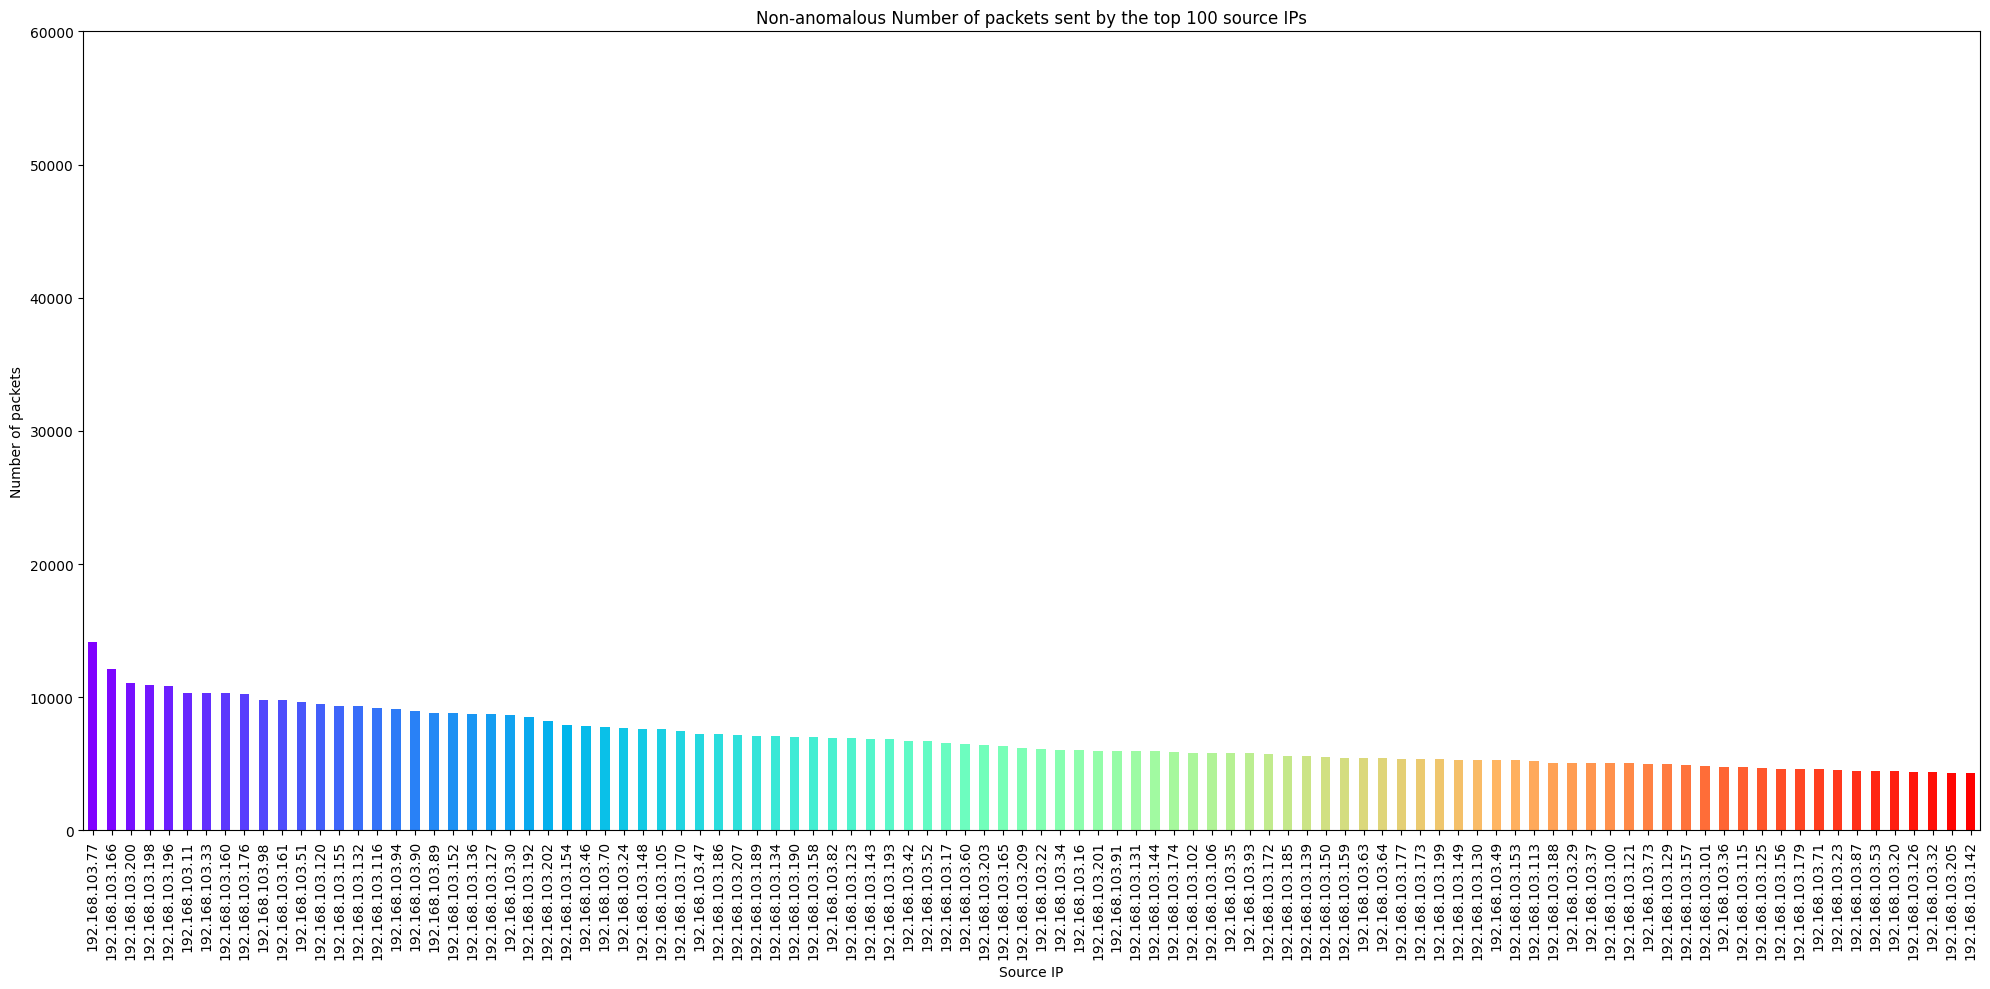

Top 10 source IPs (Non-anomalous dataset):

IP 192.168.103.77 has sent 14125 packets. Percentage: 1.49%
IP 192.168.103.166 has sent 12120 packets. Percentage: 1.28%
IP 192.168.103.200 has sent 11045 packets. Percentage: 1.17%
IP 192.168.103.198 has sent 10899 packets. Percentage: 1.15%
IP 192.168.103.196 has sent 10826 packets. Percentage: 1.14%
IP 192.168.103.11 has sent 10333 packets. Percentage: 1.09%
IP 192.168.103.33 has sent 10333 packets. Percentage: 1.09%
IP 192.168.103.160 has sent 10288 packets. Percentage: 1.09%
IP 192.168.103.176 has sent 10265 packets. Percentage: 1.08%
IP 192.168.103.98 has sent 9797 packets. Percentage: 1.03%


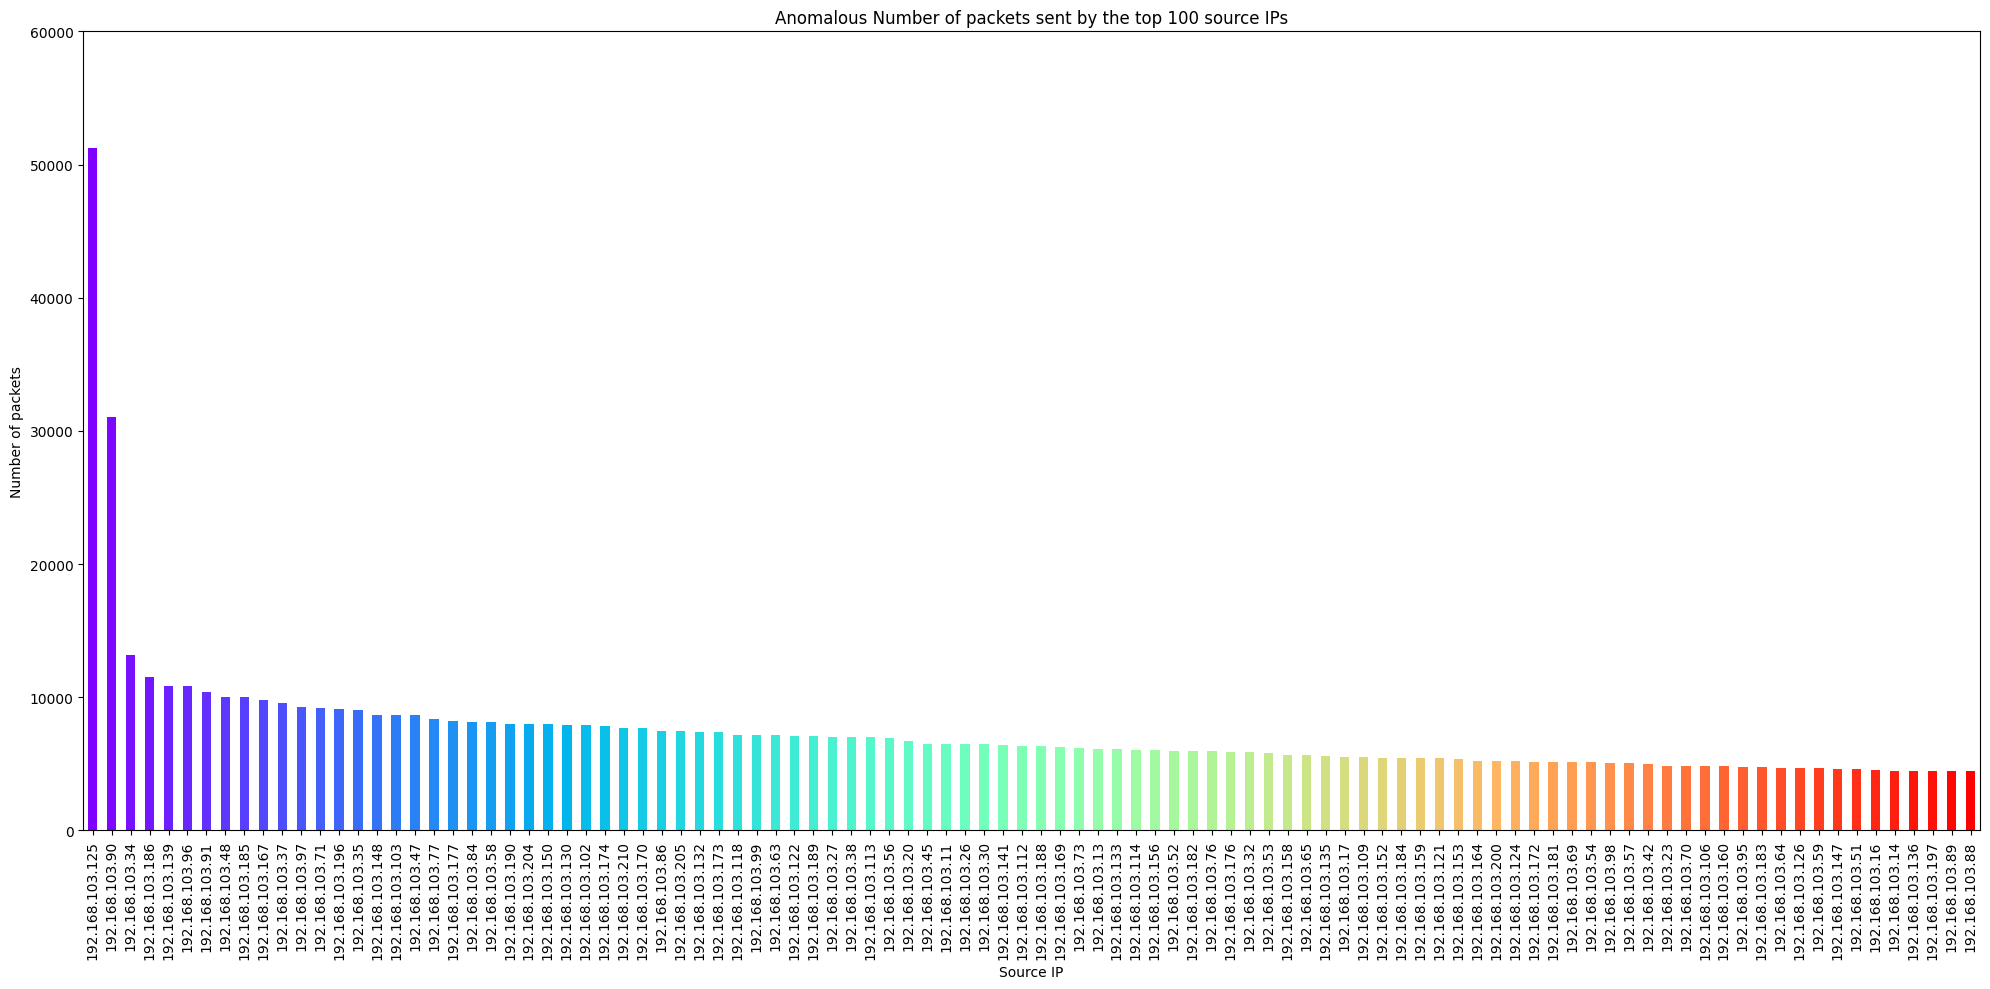

Top 10 source IPs (Anomalous dataset):

IP 192.168.103.125 has sent 51233 packets. Percentage: 4.94%
IP 192.168.103.90 has sent 31033 packets. Percentage: 2.99%
IP 192.168.103.34 has sent 13191 packets. Percentage: 1.27%
IP 192.168.103.186 has sent 11535 packets. Percentage: 1.11%
IP 192.168.103.139 has sent 10884 packets. Percentage: 1.05%
IP 192.168.103.96 has sent 10826 packets. Percentage: 1.04%
IP 192.168.103.91 has sent 10385 packets. Percentage: 1.00%
IP 192.168.103.48 has sent 10030 packets. Percentage: 0.97%
IP 192.168.103.185 has sent 10012 packets. Percentage: 0.96%
IP 192.168.103.167 has sent 9794 packets. Percentage: 0.94%


In [18]:
def top_source_ips(dataframe, frequency='1ms', top_n=100, y_lim=60000, title_prefix=''):
    dataframe = dataframe.copy()
    dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'])
    dataframe.set_index('timestamp', inplace=True)

    grouped = dataframe.groupby([pd.Grouper(freq=frequency), 'src_ip', 'dst_ip']).size().reset_index(name='packets')

    src_ip_counts = grouped.groupby('src_ip')['packets'].sum().sort_values(ascending=False)
    top_src_ip_counts = src_ip_counts.head(top_n)

    plt.figure(figsize=(20, 10))
    # Multi color bar plot
    top_src_ip_counts.plot(kind='bar', color=cm.rainbow(np.linspace(0, 1, top_n)))
    plt.title(f'{title_prefix} Number of packets sent by the top {top_n} source IPs')
    plt.xlabel('Source IP')
    plt.ylabel('Number of packets')
    plt.ylim(0, y_lim)
    plt.xticks(rotation=90)
    plt.subplots_adjust(bottom=0.3)
    plt.tight_layout()
    plt.show()

    print(f'Top 10 source IPs ({title_prefix} dataset):\n')
    for ip, count in top_src_ip_counts.head(10).items():
        print(f'IP {ip} has sent {count} packets. Percentage: {count / len(dataframe) * 100:.2f}%')


# Call the function for non-anomalous dataset
top_source_ips(non_anomalous_df, title_prefix='Non-anomalous')

# Call the function for anomalous dataset
top_source_ips(anomalous_df, title_prefix='Anomalous')

**Warning:** A high number of packets sent by a single source IP could be an indicator of a possible attack, such as a DDoS attack (2% Threshold).

#### Downloads/Uploads

The following plot shows the number of bytes uploaded and downloaded for both anomalous and non-anomalous datasets. This could be an indicator of a possible attack, as the number of bytes uploaded is higher than the number of bytes downloaded in the anomalous dataset.

We found 2 machines that have **uploaded** a higher number of bytes in the anomalous dataset:
- **192.168.103.69**
- **192.168.103.85**

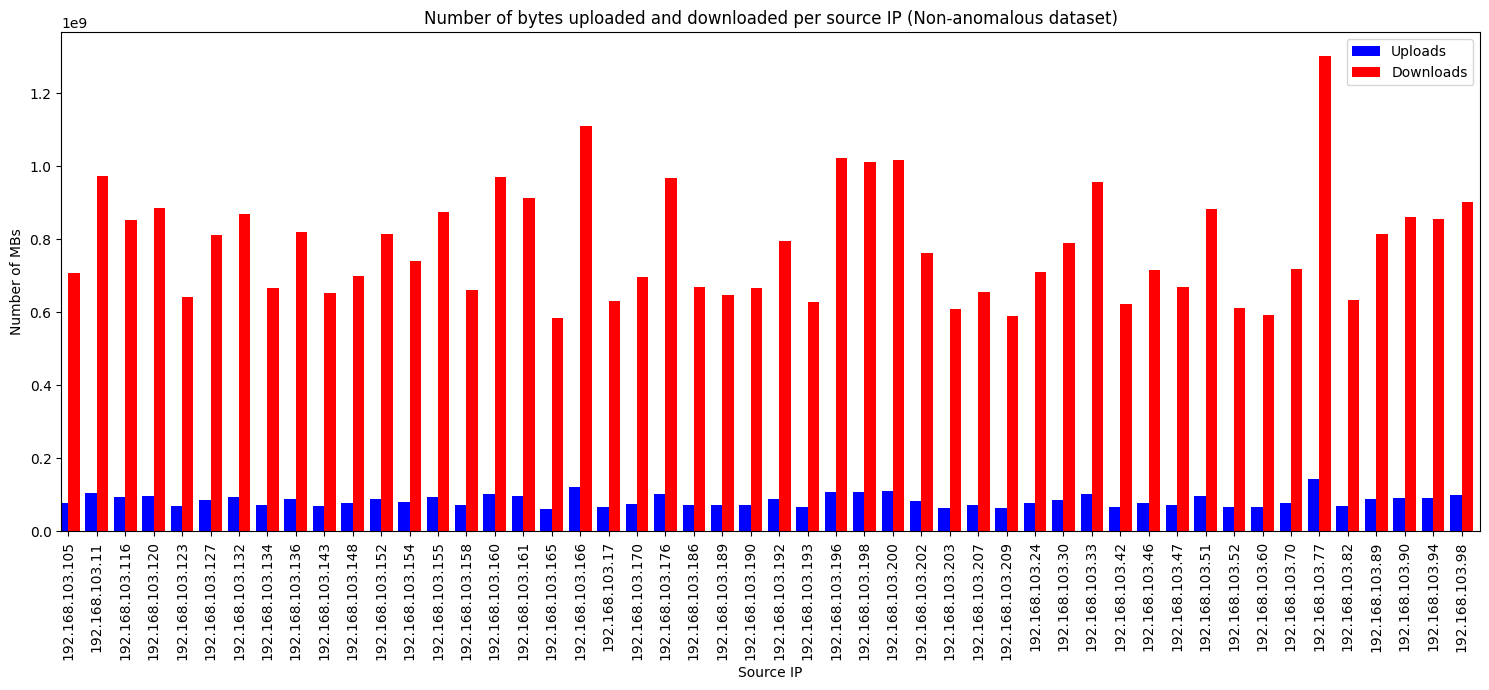

Top 10 source IPs (Non-anomalous dataset):

IP 192.168.103.77 has uploaded and downloaded 1444225901 bytes.
IP 192.168.103.166 has uploaded and downloaded 1233139941 bytes.
IP 192.168.103.196 has uploaded and downloaded 1130893120 bytes.
IP 192.168.103.200 has uploaded and downloaded 1128724110 bytes.
IP 192.168.103.198 has uploaded and downloaded 1122067581 bytes.
IP 192.168.103.11 has uploaded and downloaded 1076489362 bytes.
IP 192.168.103.160 has uploaded and downloaded 1073143168 bytes.
IP 192.168.103.176 has uploaded and downloaded 1071786173 bytes.
IP 192.168.103.33 has uploaded and downloaded 1058710040 bytes.
IP 192.168.103.161 has uploaded and downloaded 1012364070 bytes.

Average bytes uploaded (Non-anomalous dataset): 10062.21
Average bytes downloaded (Non-anomalous dataset): 92875.55

Variation between the largest and the average bytes uploaded (Non-anomalous dataset): 8.97%
Variation between the largest and the average bytes downloaded (Non-anomalous dataset): 78.92%


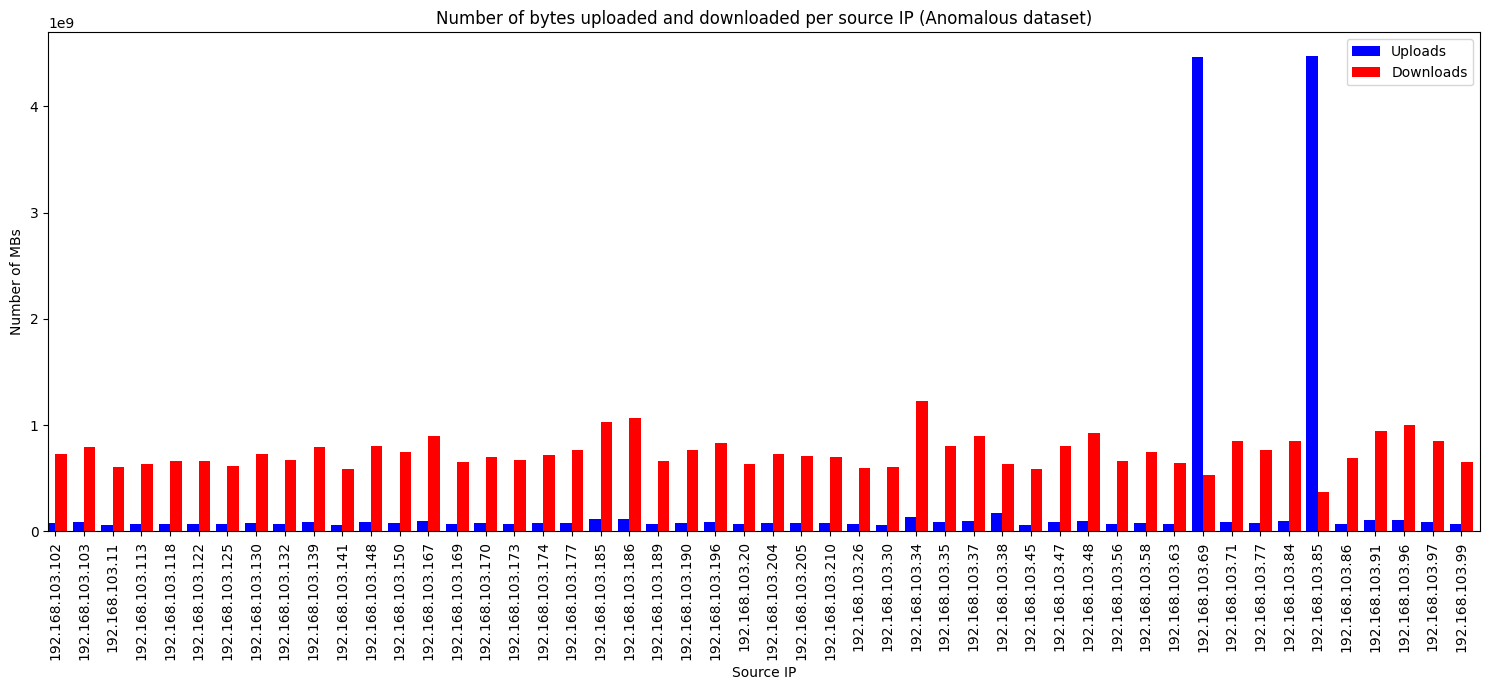

Top 10 source IPs (Anomalous dataset):

IP 192.168.103.69 has uploaded and downloaded 4991961999 bytes.
IP 192.168.103.85 has uploaded and downloaded 4838810141 bytes.
IP 192.168.103.34 has uploaded and downloaded 1360768646 bytes.
IP 192.168.103.186 has uploaded and downloaded 1184529092 bytes.
IP 192.168.103.185 has uploaded and downloaded 1142470389 bytes.
IP 192.168.103.96 has uploaded and downloaded 1106540750 bytes.
IP 192.168.103.91 has uploaded and downloaded 1047303725 bytes.
IP 192.168.103.48 has uploaded and downloaded 1023746296 bytes.
IP 192.168.103.167 has uploaded and downloaded 1000865166 bytes.
IP 192.168.103.37 has uploaded and downloaded 996712448 bytes.

Average bytes uploaded (Anomalous dataset): 18161.69
Average bytes downloaded (Anomalous dataset): 85966.95

Variation between the largest and the average bytes uploaded (Anomalous dataset): 21768.40%
Variation between the largest and the average bytes downloaded (Anomalous dataset): 94.20%


In [24]:
def download_upload(dataframe, title_prefix='', top_n=50):
    dataframe = dataframe.copy()
    # Calculate total bytes (uploads + downloads) for each source IP
    dataframe['total_bytes'] = dataframe['up_bytes'] + dataframe['down_bytes']

    # Get the top N source IPs with the highest total bytes
    top_src_ips = dataframe.groupby('src_ip')['total_bytes'].sum().nlargest(top_n).index

    # Filter the dataframe to include only the top N source IPs
    top_data = dataframe[dataframe['src_ip'].isin(top_src_ips)]

    # Plot the data
    plt.figure(figsize=(15, 7))  # Adjusting figure size for better readability
    top_data.groupby('src_ip')['up_bytes'].sum().plot(kind='bar', width=0.4, color='blue', position=1, label='Uploads')
    top_data.groupby('src_ip')['down_bytes'].sum().plot(kind='bar', width=0.4, color='red', position=0,
                                                        label='Downloads')

    plt.title(f'Number of bytes uploaded and downloaded per source IP ({title_prefix} dataset)')
    plt.xlabel('Source IP')
    plt.ylabel('Number of MBs')
    plt.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    top_n = 10
    print(f'Top {top_n} source IPs ({title_prefix} dataset):\n')
    for ip, count in top_data.groupby('src_ip')['total_bytes'].sum().nlargest(top_n).items():
        print(f'IP {ip} has uploaded and downloaded {count} bytes.')

    print(f'\nAverage bytes uploaded ({title_prefix} dataset): {dataframe["up_bytes"].mean():.2f}')
    print(f'Average bytes downloaded ({title_prefix} dataset): {dataframe["down_bytes"].mean():.2f}\n')
    
    print(f'Variation between the largest and the average bytes uploaded ({title_prefix} dataset): {top_data["up_bytes"].max() / dataframe["up_bytes"].mean():.2f}%')
    print(f'Variation between the largest and the average bytes downloaded ({title_prefix} dataset): {top_data["down_bytes"].max() / dataframe["down_bytes"].mean():.2f}%')
    


# Call the function for non-anomalous dataset
download_upload(non_anomalous_df, title_prefix='Non-anomalous')

# Call the function for anomalous dataset
download_upload(anomalous_df, title_prefix='Anomalous')

**Warning:** A high number of bytes uploaded by a single source IP could be an indicator of a possible attack, such as data exfiltration (variation bigger than 85%).

### Download/Upload on DNS packets

However, the number of bytes uploaded and downloaded for DNS packets showcase that the previous detected machines (in the number of packets sent) have the highest number of bytes uploaded and downloaded for DNS packets.

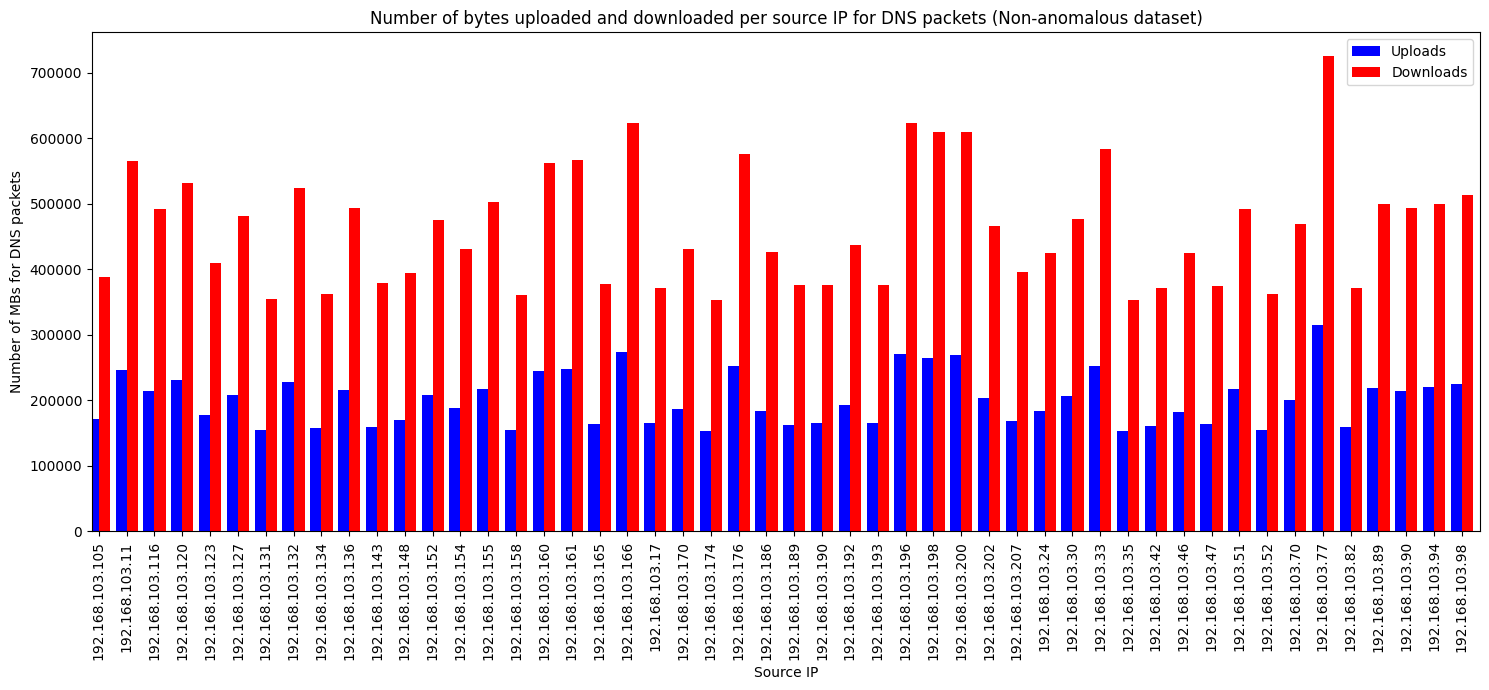

Number of bytes uploaded for DNS packets (Non-anomalous dataset): 22619285
Number of bytes downloaded for DNS packets (Non-anomalous dataset): 52003133
IP with the highest uploaded bytes (Non-anomalous dataset): 192.168.103.77
Uploaded bytes for the source IP with the highest uploaded bytes (Non-anomalous dataset): 315126
Downloaded bytes for the source IP with the highest uploaded bytes (Non-anomalous dataset): 725030
Ratio of uploaded and downloaded bytes for the source IP with the highest uploaded bytes (Non-anomalous dataset): 0.43463856667999945


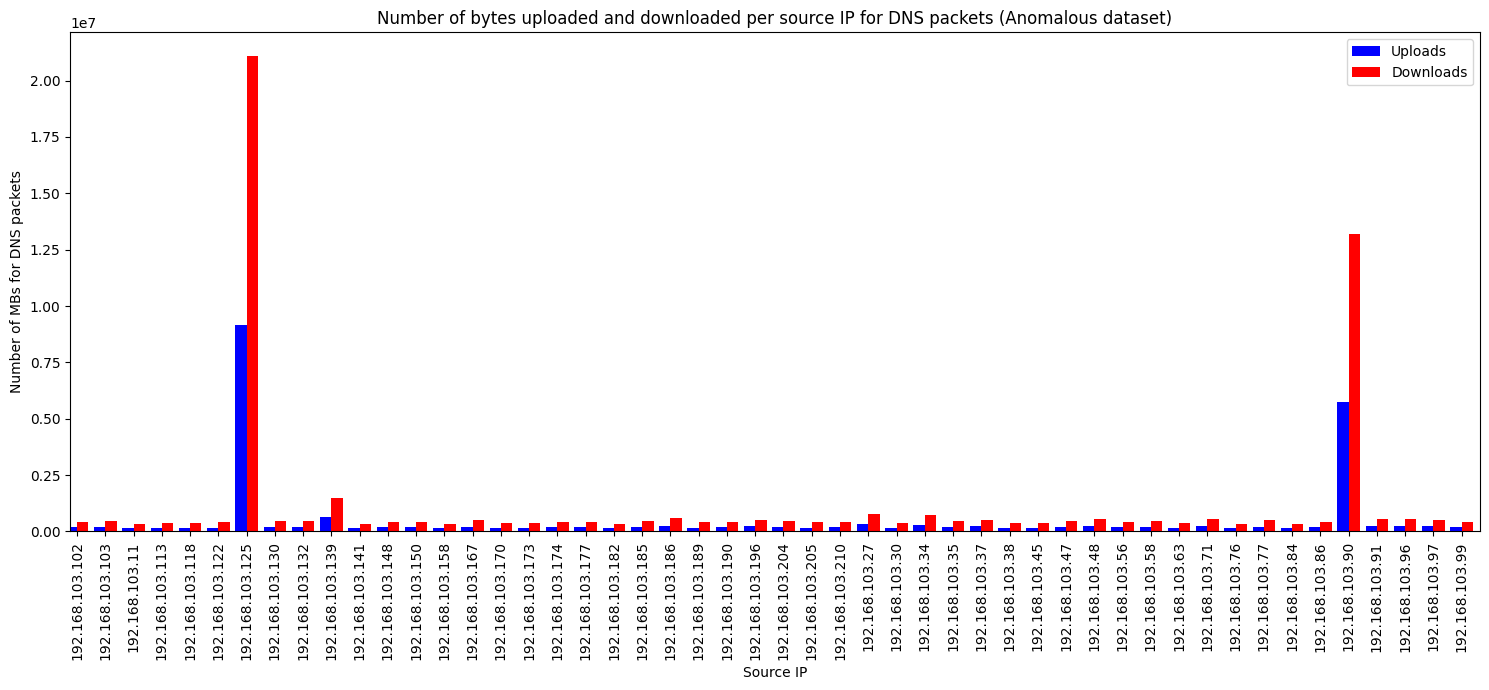

Number of bytes uploaded for DNS packets (Anomalous dataset): 38066508
Number of bytes downloaded for DNS packets (Anomalous dataset): 87488117
IP with the highest uploaded bytes (Anomalous dataset): 192.168.103.125
Uploaded bytes for the source IP with the highest uploaded bytes (Anomalous dataset): 9160062
Downloaded bytes for the source IP with the highest uploaded bytes (Anomalous dataset): 21083787
Ratio of uploaded and downloaded bytes for the source IP with the highest uploaded bytes (Anomalous dataset): 0.4344599952560705


In [10]:
def download_upload_dns(dataframe, title_prefix='', top_n=50):
    dns_port = 53
    # Filter the dataframe to include only DNS packets
    dns_data = dataframe[dataframe['port'] == dns_port].copy()

    # Calculate total bytes (uploads + downloads) for each source IP
    dns_data['total_bytes'] = dns_data['up_bytes'] + dns_data['down_bytes']

    # Get the top N source IPs with the highest total bytes
    top_src_ips = dns_data.groupby('src_ip')['total_bytes'].sum().nlargest(top_n).index

    # Filter the dataframe to include only the top N source IPs
    top_data = dns_data[dns_data['src_ip'].isin(top_src_ips)]

    # Plot the data
    plt.figure(figsize=(15, 7))  # Adjusting figure size for better readability
    top_data.groupby('src_ip')['up_bytes'].sum().plot(kind='bar', width=0.4, color='blue', position=1, label='Uploads')
    top_data.groupby('src_ip')['down_bytes'].sum().plot(kind='bar', width=0.4, color='red', position=0,
                                                        label='Downloads')

    plt.title(f'Number of bytes uploaded and downloaded per source IP for DNS packets ({title_prefix} dataset)')
    plt.xlabel('Source IP')
    plt.ylabel('Number of MBs for DNS packets')
    plt.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    print(f'Number of bytes uploaded for DNS packets ({title_prefix} dataset):', dns_data['up_bytes'].sum())
    print(f'Number of bytes downloaded for DNS packets ({title_prefix} dataset):', dns_data['down_bytes'].sum())

    # Get the src_ip with the highest number of bytes uploaded
    highest_uploaded_ip = dns_data.groupby('src_ip')['up_bytes'].sum().idxmax()
    uploaded_bytes = dns_data[dns_data['src_ip'] == highest_uploaded_ip]['up_bytes'].sum()
    downloaded_bytes = dns_data[dns_data['src_ip'] == highest_uploaded_ip]['down_bytes'].sum()

    print(f'IP with the highest uploaded bytes ({title_prefix} dataset):', highest_uploaded_ip)
    print(f'Uploaded bytes for the source IP with the highest uploaded bytes ({title_prefix} dataset):', uploaded_bytes)
    print(f'Downloaded bytes for the source IP with the highest uploaded bytes ({title_prefix} dataset):',
          downloaded_bytes)
    print(
        f'Ratio of uploaded and downloaded bytes for the source IP with the highest uploaded bytes ({title_prefix} dataset):',
        uploaded_bytes / downloaded_bytes)


# Call the function for non-anomalous dataset
download_upload_dns(non_anomalous_df, title_prefix='Non-anomalous')

# Call the function for anomalous dataset
download_upload_dns(anomalous_df, title_prefix='Anomalous')

**Warning:** A high ratio of uploaded and downloaded bytes could be an indicator of data exfiltration (aka DNS tunneling).

### Geolocation of all the traffic sent

From the traffic sent, we can see that the majority of the traffic is sent to the United States. This is the same for both the anomalous and non-anomalous datasets.

In [11]:
gi = pygeoip.GeoIP('./datasets/GeoIP_DBs/GeoIP.dat')

# Is destination IPv4 a public address?
NET = ipaddress.IPv4Network('192.168.103.0/24')
bpublic = non_anomalous_df.apply(lambda x: ipaddress.IPv4Address(x['dst_ip']) not in NET, axis=1)
bpublic2 = anomalous_df.apply(lambda x: ipaddress.IPv4Address(x['dst_ip']) not in NET, axis=1)

# Geolocalization of public destination adddress
country_code = non_anomalous_df[bpublic]['dst_ip'].apply(lambda y: gi.country_code_by_addr(y)).to_frame(
    name='country_code')
country_code2 = anomalous_df[bpublic2]['dst_ip'].apply(lambda y: gi.country_code_by_addr(y)).to_frame(
    name='country_code')

# Add country code count
country_code = country_code['country_code'].value_counts().sort_values(ascending=False)
country_code2 = country_code2['country_code'].value_counts().sort_values(ascending=False)

country_code = country_code / non_anomalous_df.shape[0] * 100
country_code2 = country_code2 / anomalous_df.shape[0] * 100

# Show the country code count
print('Non-anomalous dataset:')
print(country_code)
print('Anomalous dataset:')
print(country_code2)

Non-anomalous dataset:
country_code
US    35.264637
PT    26.990683
NA     2.024198
NL     1.989970
DE     1.815556
GB     0.850837
ES     0.580184
BR     0.423411
IE     0.063385
IN     0.058420
AU     0.048806
SG     0.035284
ZA     0.032643
HK     0.027572
JP     0.023664
SE     0.022396
FR     0.022185
KR     0.021973
IT     0.021128
CA     0.018804
CN     0.018382
CH     0.010247
ID     0.008029
AE     0.007078
IL     0.006550
NO     0.004543
MY     0.003275
BH     0.002218
SA     0.002113
BE     0.001902
CL     0.001479
MX     0.001162
AP     0.000951
OM     0.000739
NZ     0.000528
PL     0.000528
AR     0.000211
Name: count, dtype: float64
Anomalous dataset:
country_code
US    32.510430
PT    24.892034
NA     1.842787
NL     1.799620
DE     1.693245
        ...    
IQ     0.000193
IS     0.000096
MD     0.000096
VN     0.000096
MX     0.000096
Name: count, Length: 75, dtype: float64


Given a threshold of 1% in variation, we can see the following countries that have a significant variation in the number of packets sent.

Being the following countries new in the anomalous dataset:
- **RU**: Russia
- **UA**: Ukraine

In [12]:
# Create a list to store the comparison results
comp_list = []

# Iterate through the country codes in the non-anomalous dataset
for country in country_code.index:
    if country in country_code2:
        # Calculate the difference for existing countries in both datasets
        dif = country_code2[country] - country_code[country]
        comp_list.append({'country': country, 'variation': dif, 'is_new': False})
    else:
        # Handle the case where the country code is not in the anomalous dataset
        comp_list.append({'country': country, 'variation': -country_code[country], 'is_new': False})

# Handle the new country codes that are only in the anomalous dataset
for country in country_code2.index:
    if country not in country_code:
        comp_list.append({'country': country, 'variation': country_code2[country], 'is_new': True})

# Convert the list to a DataFrame
comp = pd.DataFrame(comp_list)

# Print the comp DataFrame given a threshold of 1% in variation
threshold = 0.01
print(comp[comp['variation'] > threshold])

   country  variation  is_new
7       BR   0.013558   False
9       IN   0.014135   False
20      CN   0.148023   False
37      RU   0.273937    True
38      UA   0.011370    True


**Warning:** A high variation of packets sent to RU (Russia) and UA (Ukraine) could be an indicator of a possible attack, such as data exfiltration or C&C communication.

Now we are going to analyze to see which internal machines are sending traffic to these new countries.

This flagged the following internal machines:
- **192.168.103.185**
- **192.168.103.84**
- **192.168.103.169**

In [14]:
sus_ips = []
sus_geo = ['RU', 'UA']

for geo in sus_geo:
    found_ips = anomalous_df[anomalous_df['dst_ip'].apply(lambda x: gi.country_code_by_addr(x) == geo)]['src_ip']
    sus_ips.extend([ip for ip in found_ips if ip not in sus_ips])

print(f'The following internal machines are sending traffic to the new countries: {sus_ips}')

The following internal machines are sending traffic to the new countries: ['192.168.103.169', '192.168.103.84', '192.168.103.185']


**Warning:** the anomalous dataset has **38** new country codes that do not appear in the non-anomalous dataset. This could indicate that the traffic is sent to a different location, which could be an indicator of an attack.

In [13]:
new_country_codes = set(country_code2.index) - set(country_code.index)
new_country_codes_list = list(new_country_codes)
new_country_codes_df = country_code2.loc[new_country_codes_list].sort_values(ascending=False)

print(
    f'The anomalous dataset has {len(new_country_codes_df)} new country codes that do not appear in the non-anomalous dataset.')
print(new_country_codes_df)

The anomalous dataset has 38 new country codes that do not appear in the non-anomalous dataset.
country_code
RU    0.273937
UA    0.011370
LB    0.008094
MM    0.007901
KG    0.002794
      0.001542
TW    0.001349
EE    0.001253
LU    0.001156
TH    0.000964
SI    0.000964
AT    0.000771
CZ    0.000771
ME    0.000674
BY    0.000578
EU    0.000578
GL    0.000578
UZ    0.000482
MV    0.000482
PK    0.000482
KH    0.000482
VG    0.000385
EG    0.000385
BN    0.000385
DM    0.000289
GE    0.000289
BD    0.000289
TR    0.000289
KZ    0.000289
BA    0.000289
SK    0.000289
RO    0.000289
GP    0.000193
IQ    0.000193
AG    0.000193
MD    0.000096
IS    0.000096
VN    0.000096
Name: count, dtype: float64


### Traffic Sent by the possible compromised machines

For that reason, we will analyze the traffic sent by the potential infected machines.

To do so, we will need to have the geographical location of the destination IP addresses. We will use the GeoIP database to get the location of the destination IP addresses.

In [15]:
sus_ips = ['192.168.103.185', '192.168.103.84', '192.168.103.169']
anomalous_df = pd.read_parquet('datasets/dataset3/test3.parquet')


def get_domain_name(ip):
    try:
        return dns.resolver.resolve(dns.reversename.from_address(ip), 'PTR')[0].to_text()
    except:
        return None


def traffic_sent_by_ip_domain(dataframe, ip, frequency='1min'):
    dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'])

    internal_network = ipaddress.IPv4Network('192.168.103.0/24')
    dataframe = dataframe[~dataframe['dst_ip'].apply(lambda x: ipaddress.ip_address(x) in internal_network)]

    dataframe = dataframe.copy()  # Create a copy to avoid SettingWithCopyWarning

    dataframe.loc[:, 'timestamp_minute'] = dataframe['timestamp'].dt.floor('min')  # Using .loc to set values

    # DNS resolution
    dataframe['domain'] = dataframe['dst_ip'].map(get_domain_name)

    dataframe = dataframe.dropna(subset=['domain'])

    # Calculate the sum of upload and download bytes for each DNS name
    dataframe_grouped = dataframe.groupby('domain').agg({'up_bytes': 'sum', 'down_bytes': 'sum'}).reset_index()

    # Plot the data
    plt.figure(figsize=(20, 10))
    plt.plot(dataframe_grouped['timestamp_minute'], dataframe_grouped['up_bytes'], label='Uploads')
    plt.plot(dataframe_grouped['timestamp_minute'], dataframe_grouped['down_bytes'], label='Downloads')
    plt.title(f'Number of bytes uploaded and downloaded by {ip} per minute')
    plt.xlabel('Time')
    plt.ylabel('Number of bytes')
    plt.legend()
    plt.show()


for ip in sus_ips:
    print(f'Traffic sent by {ip}:')
    # traffic_sent_by_ip_domain(anomalous_df, ip)

Traffic sent by 192.168.103.185:
Traffic sent by 192.168.103.84:
Traffic sent by 192.168.103.169:


### External Traffic Sent
#### calcular a quantidade total de up_bytes e down_bytes por IP de origem

In [33]:
# Print the server dataset
server_df = pd.read_parquet('datasets/dataset3/servers3.parquet')
server_df.head()

# Calcular a quantidade total de up_bytes e down_bytes por IP de origem
src_traffic = server_df.groupby('src_ip').agg({
    'up_bytes': 'sum',
    'down_bytes': 'sum',
    'up_bytes': 'count'
})

# Mostrar os resultados ordenados pela quantidade total de up_bytes
print(src_traffic.sort_values(by='up_bytes', ascending=False))

# Calculate the ratio between up_bytes and down_bytes
server_df['up_down_ratio'] = server_df['up_bytes'] / server_df['down_bytes']

# Print the ratio between up_bytes and down_bytes
print(server_df[['src_ip', 'up_down_ratio']])
print(server_df['up_down_ratio'].describe())


                up_bytes  down_bytes
src_ip                              
82.155.123.32       9848   945409009
82.155.123.17       9295   893390732
82.155.123.47       7130   675959768
82.155.123.69       6907   674225122
82.155.123.29       6815   656955693
...                  ...         ...
82.155.123.208       654    61410301
82.155.123.122       610    56814757
82.155.123.125       396    38297648
82.155.123.92        131    12481276
82.155.123.174        57     4853585

[199 rows x 2 columns]
                src_ip  up_down_ratio
index                                
546889   82.155.123.32       0.144602
546890   82.155.123.32       0.172519
546891   82.155.123.32       0.169273
546892   82.155.123.32       0.138934
546893   82.155.123.32       0.073017
...                ...            ...
681915  82.155.123.113       0.127741
681916  82.155.123.113       0.107414
681917  82.155.123.113       0.115652
681918  82.155.123.113       0.082297
681919  82.155.123.113       0.107072



#### Ports Used (Application Layer Protocols)

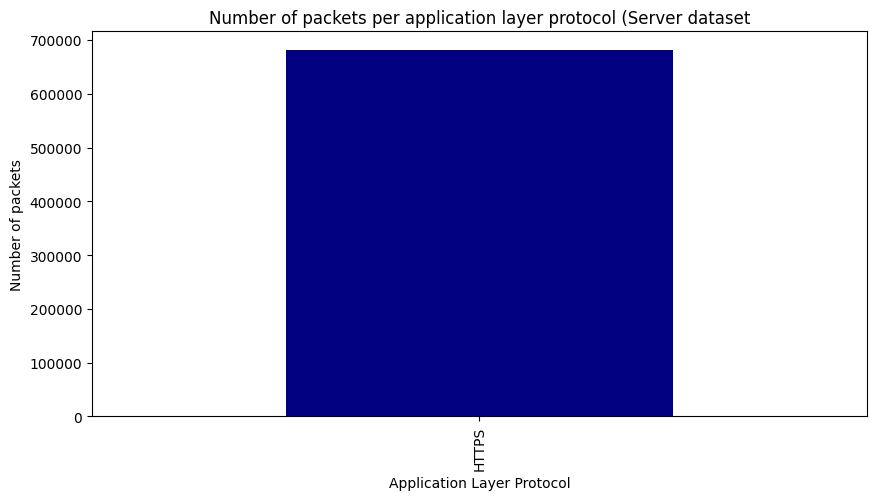

Ratio of HTTPS packets (Server dataset): 100.00%
Ratio of DNS packets (Server dataset): 0.00%


In [37]:
application_protocols = {
    '80': 'HTTP',
    '443': 'HTTPS',
    '22': 'SSH',
    '53': 'DNS',
    '21': 'FTP',
    '25': 'SMTP',
}

# Calcular a distribuição de protocolos por porta
def protocol_distribution(dataframe, title_prefix=''):
    protocol_series = dataframe['port'].astype(str).map(application_protocols)

    if protocol_series.isnull().values.any():
        protocol_series = dataframe['port']

    plt.figure(figsize=(10, 5))
    protocol_series.value_counts().plot(kind='bar', color=['navy', 'green'])
    plt.title(f'Number of packets per application layer protocol ({title_prefix} dataset')
    plt.xlabel('Application Layer Protocol')
    plt.ylabel('Number of packets')
    plt.show()

    print(
        f'Ratio of HTTPS packets ({title_prefix} dataset): {len(dataframe[dataframe["port"] == 443]) / len(dataframe) * 100:.2f}%')
    print(
        f'Ratio of DNS packets ({title_prefix} dataset): {len(dataframe[dataframe["port"] == 53]) / len(dataframe) * 100:.2f}%')
    
# Chamar a função para o dataset server
protocol_distribution(server_df, title_prefix='Server')



#### Number of packets sent by the top 100 source IPs

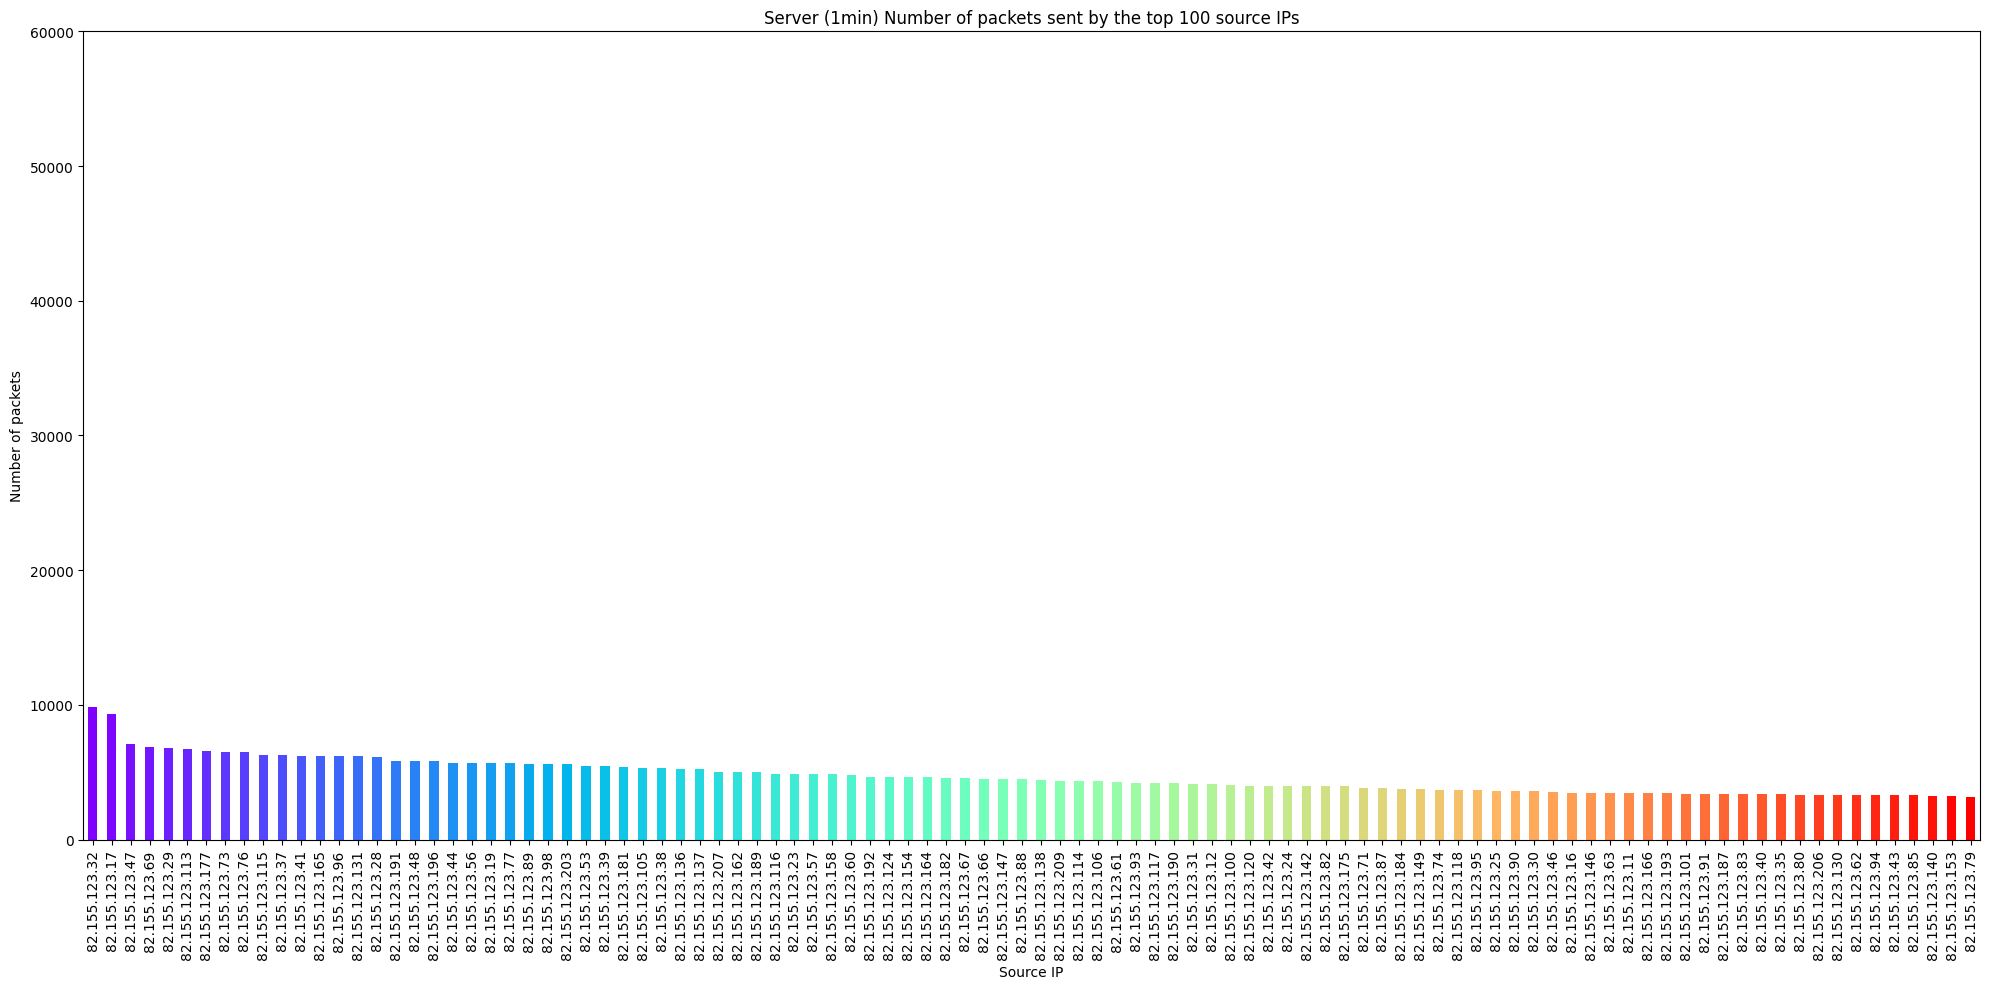

Top 10 source IPs (Server (1min) dataset):

IP 82.155.123.32 has sent 9848 packets. Percentage: 1.44%
IP 82.155.123.17 has sent 9295 packets. Percentage: 1.36%
IP 82.155.123.47 has sent 7130 packets. Percentage: 1.05%
IP 82.155.123.69 has sent 6907 packets. Percentage: 1.01%
IP 82.155.123.29 has sent 6815 packets. Percentage: 1.00%
IP 82.155.123.113 has sent 6716 packets. Percentage: 0.98%
IP 82.155.123.177 has sent 6610 packets. Percentage: 0.97%
IP 82.155.123.73 has sent 6514 packets. Percentage: 0.96%
IP 82.155.123.76 has sent 6500 packets. Percentage: 0.95%
IP 82.155.123.115 has sent 6315 packets. Percentage: 0.93%


In [43]:
def top_source_ips(dataframe, frequency='1min', top_n=100, y_lim=60000, title_prefix=''):
    dataframe = dataframe.copy()
    dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'], unit='s')
    dataframe.set_index('timestamp', inplace=True)

    grouped = dataframe.groupby([pd.Grouper(freq=frequency), 'src_ip']).size().reset_index(name='packets')

    src_ip_counts = grouped.groupby('src_ip')['packets'].sum().sort_values(ascending=False)
    top_src_ip_counts = src_ip_counts.head(top_n)

    plt.figure(figsize=(20, 10))
    # Multi color bar plot
    top_src_ip_counts.plot(kind='bar', color=cm.rainbow(np.linspace(0, 1, top_n)))
    plt.title(f'{title_prefix} Number of packets sent by the top {top_n} source IPs')
    plt.xlabel('Source IP')
    plt.ylabel('Number of packets')
    plt.ylim(0, y_lim)
    plt.xticks(rotation=90)
    plt.subplots_adjust(bottom=0.3)
    plt.tight_layout()
    plt.show()

    print(f'Top 10 source IPs ({title_prefix} dataset):\n')
    for ip, count in top_src_ip_counts.head(10).items():
        print(f'IP {ip} has sent {count} packets. Percentage: {count / len(dataframe) * 100:.2f}%')

# Chamar a função para o dataset server com frequência de 1 minuto
top_source_ips(server_df, frequency='1min', title_prefix='Server (1min)')

#### Trafego por minuto para os 10 IPs de origem
Parece que o IP 82.155.123.113 apresenta um padrão de tráfego consistente, sem as variações vistas nos outros IPs. Este comportamento pode ser suspeito, especialmente se comparado com a variabilidade normal de tráfego observada nos outros IPs.


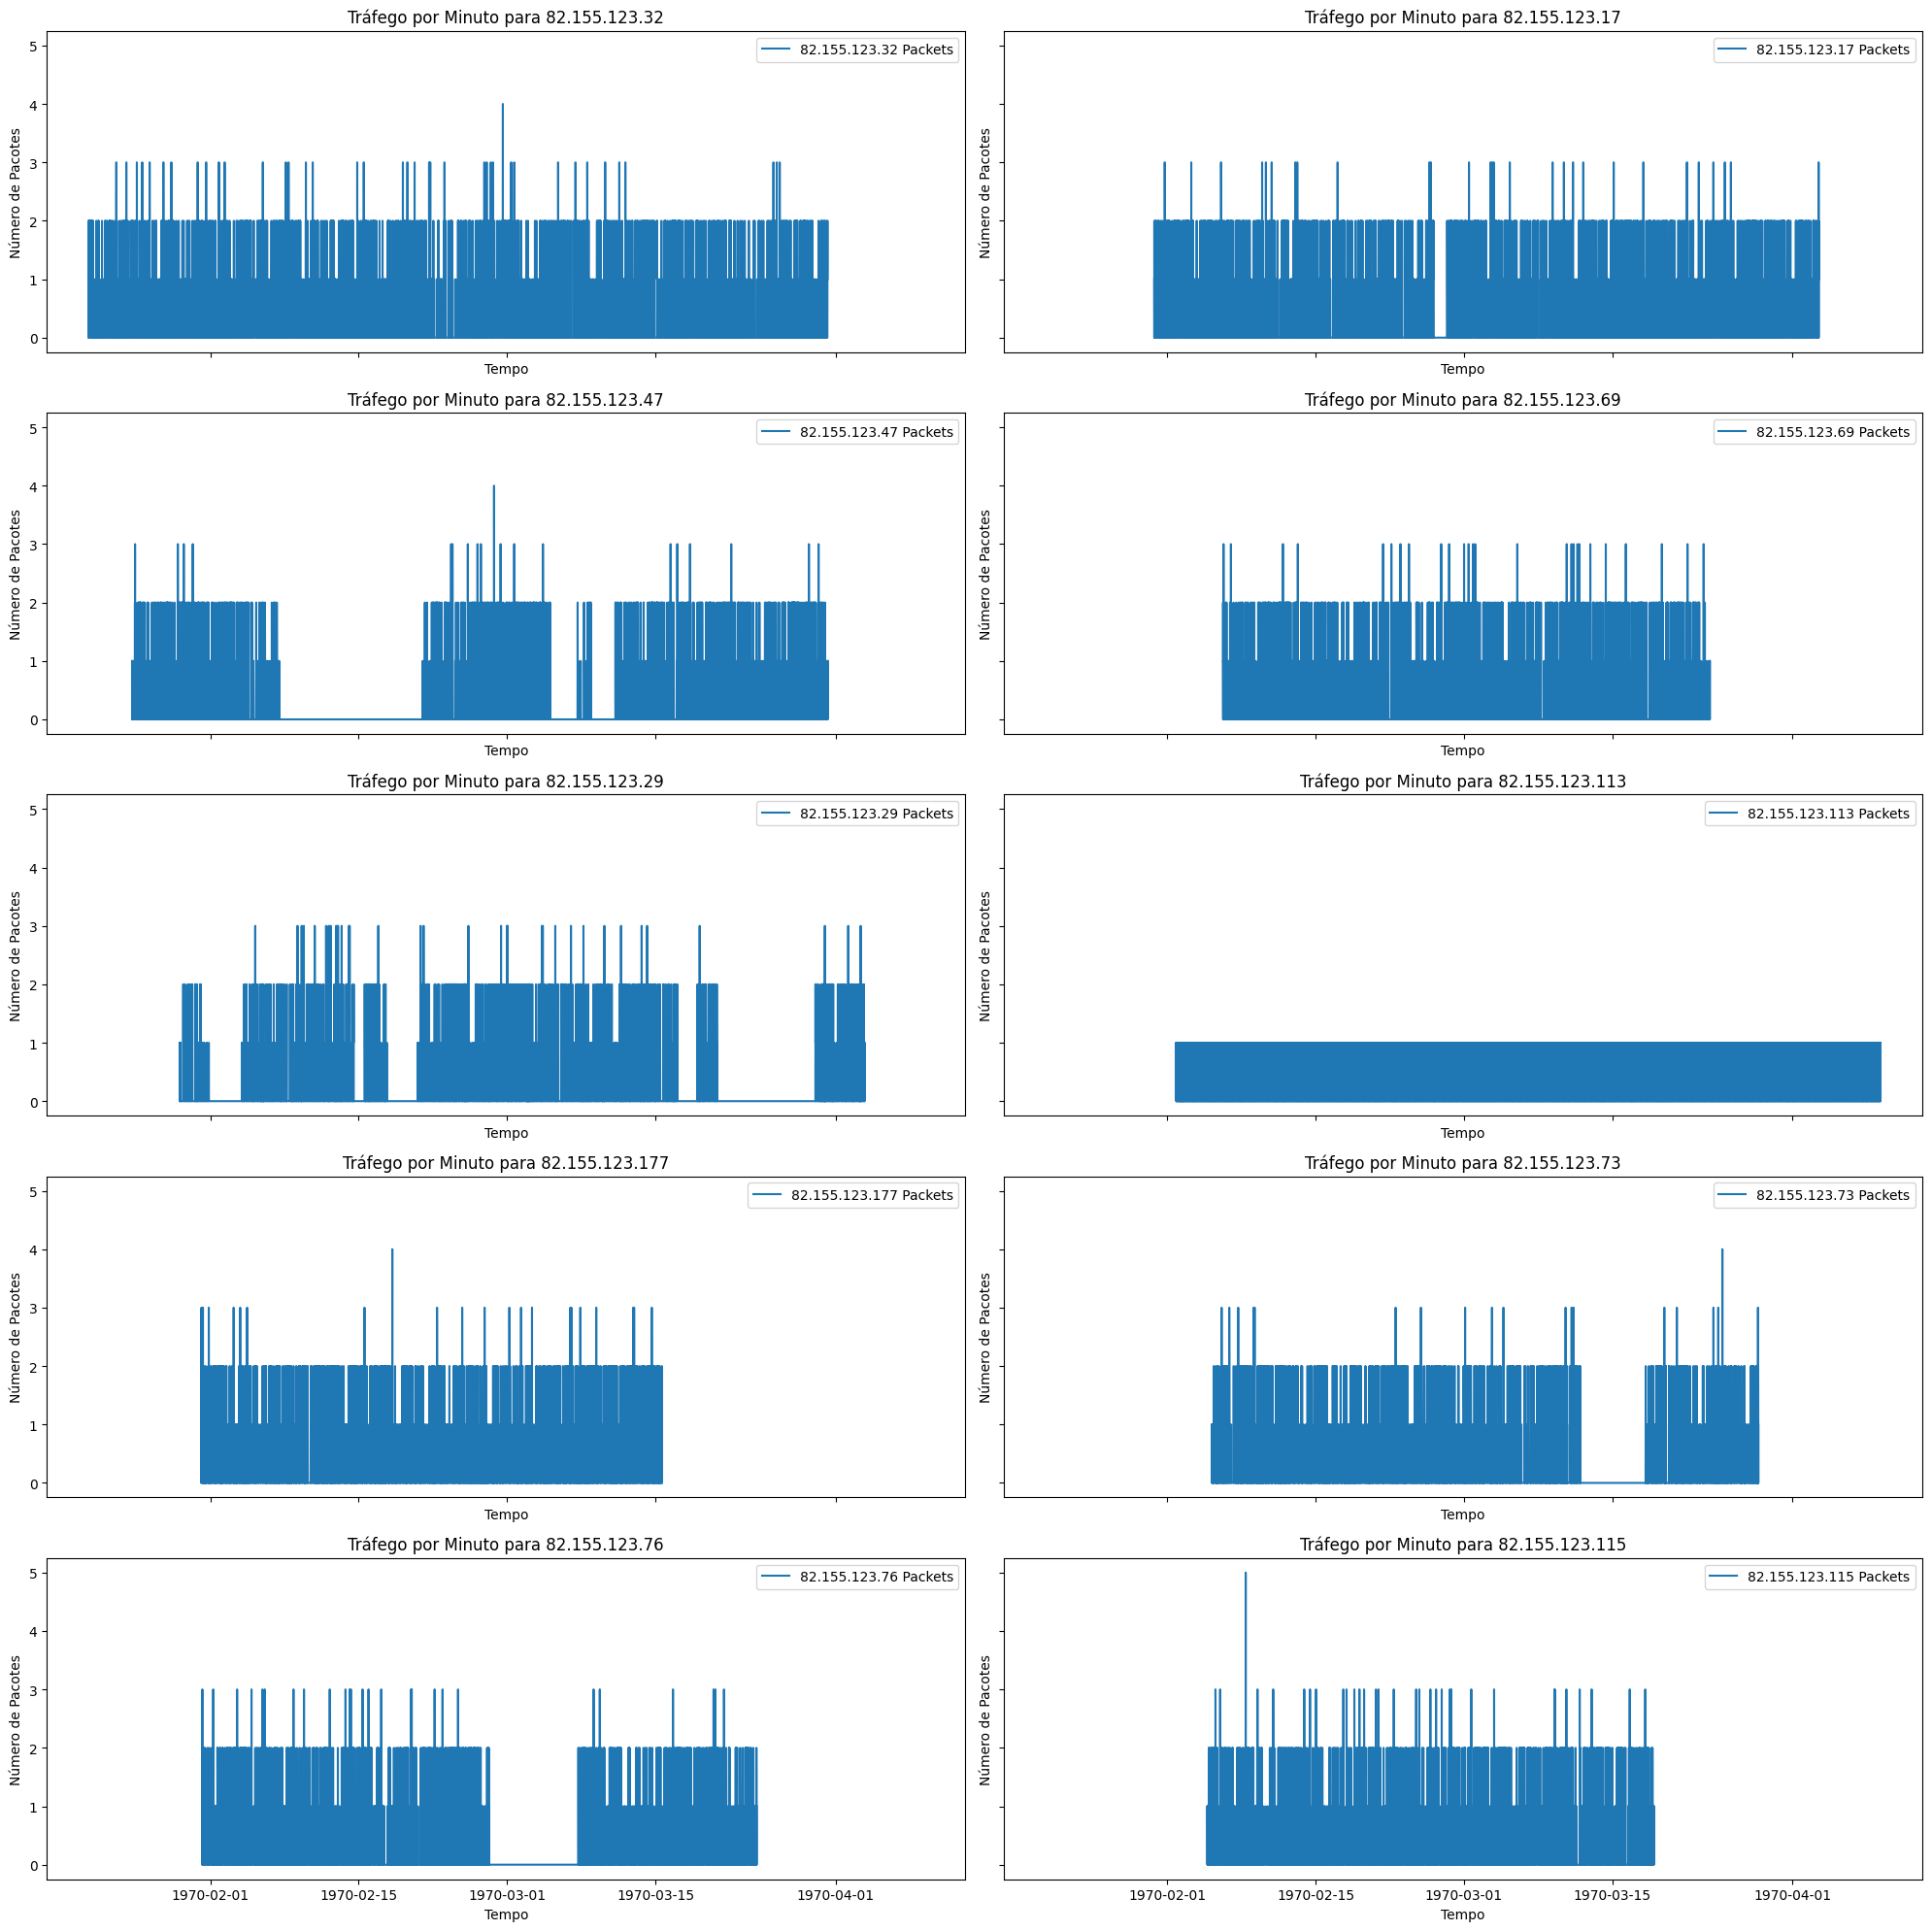

In [44]:
# Converter a coluna de tempo para datetime
server_df['timestamp'] = pd.to_datetime(server_df['timestamp'], unit='s')

# Top 10 IPs de origem
top_ips = ['82.155.123.32', '82.155.123.17', '82.155.123.47', '82.155.123.69', '82.155.123.29', 
           '82.155.123.113', '82.155.123.177', '82.155.123.73', '82.155.123.76', '82.155.123.115']

# Resample por minuto e somar o número de pacotes para cada IP de origem
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 20), sharex=True, sharey=True)
axes = axes.flatten()

for i, ip in enumerate(top_ips):
    hourly_traffic = server_df[server_df['src_ip'] == ip].resample('1min', on='timestamp').size()
    axes[i].plot(hourly_traffic.index, hourly_traffic, label=f'{ip} Packets')
    axes[i].set_title(f'Tráfego por Minuto para {ip}')
    axes[i].set_xlabel('Tempo')
    axes[i].set_ylabel('Número de Pacotes')
    axes[i].legend()

plt.tight_layout()
plt.show()

#### Estatísticas Descritivas

Para investigar mais detalhadamente, é necessário analisar os dados de tráfego do 82.155.123.113 de forma mais abrangente. Vamos calcular algumas estatísticas descritivas para os pacotes enviados por este IP.

In [61]:
# Calcular estatísticas descritivas para pacotes enviados por IP 82.155.123.113
ip_113 = server_df[server_df['src_ip'] == '82.155.123.113']
print(ip_113['up_bytes'].describe())


count     6716.000000
mean     11462.227963
std       6372.150783
min       1550.000000
25%       7038.000000
50%      10045.000000
75%      14162.500000
max      71369.000000
Name: up_bytes, dtype: float64


#### Vamos examinar alguns detalhes adicionais e realizar análises para identificar possíveis anomalias:
- Volume Total de Tráfego: Verificar se o volume total de tráfego enviado e recebido está em linha com outros IPs ou se há uma discrepância significativa.
- Distribuição ao Longo do Tempo: Analisar a consistência do tráfego ao longo do tempo pode ajudar a identificar períodos de atividade anômala.
- Comparação de Média e Mediana: Diferenças significativas entre média e mediana podem indicar a presença de outliers ou tráfego irregular.
- Distribuição dos Bytes: Uma distribuição diferente do padrão pode indicar comportamentos suspeitos.

Total Up Bytes: 76980323
Total Down Bytes: 654338920


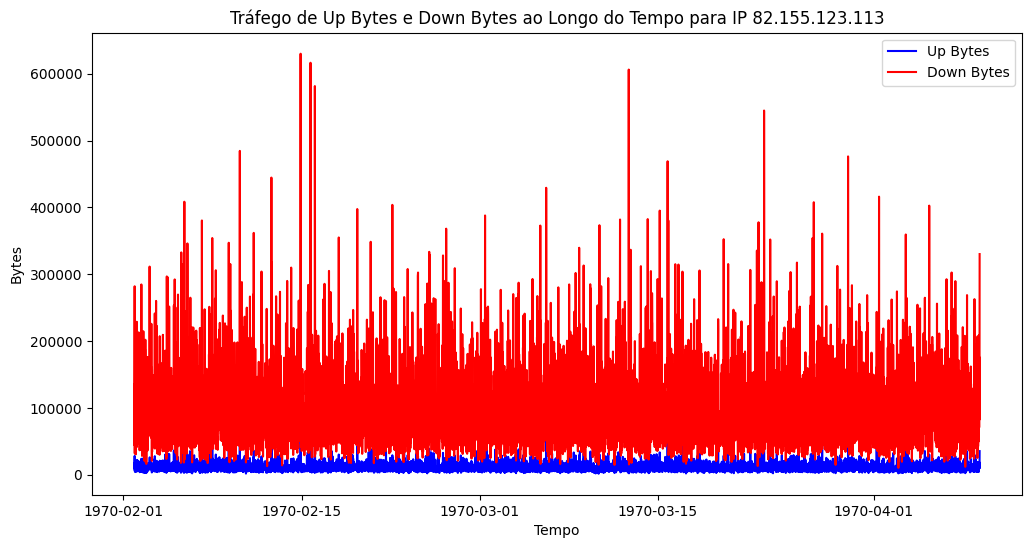

Média de Up Bytes: 11462.227963073257
Mediana de Up Bytes: 10045.0
Média de Down Bytes: 97429.85705777249
Mediana de Down Bytes: 83753.5


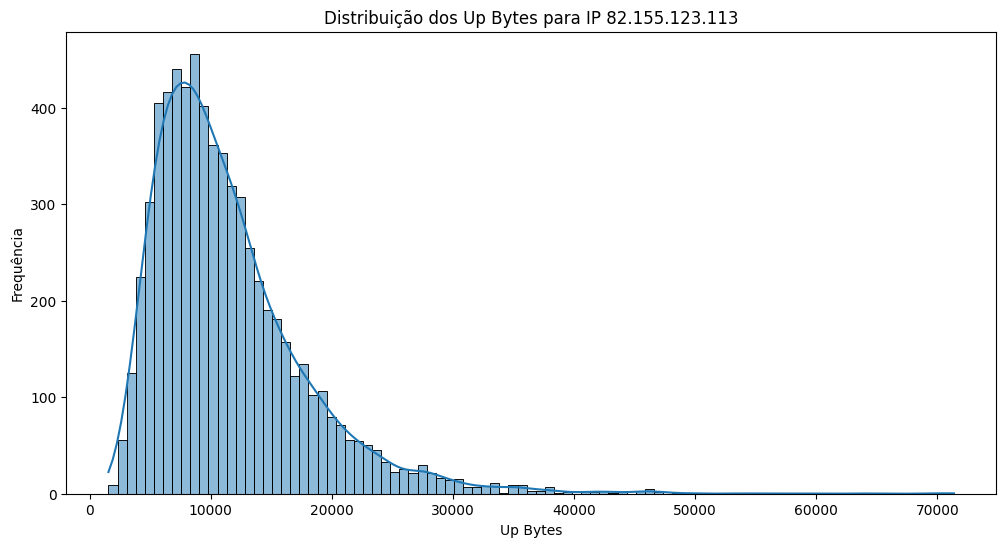

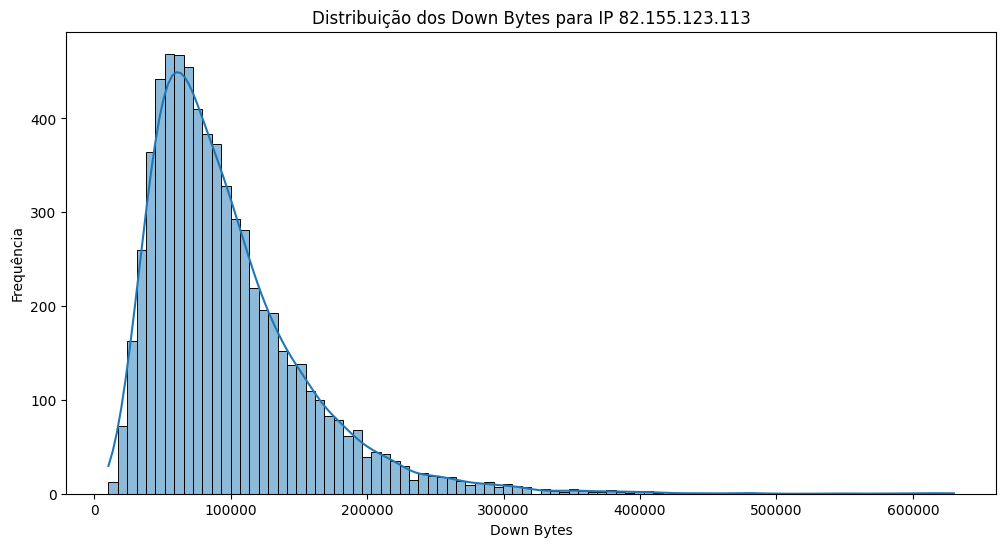

In [62]:
import seaborn as sns
# Filtrar os dados para o IP 82.155.123.113
ip_data = server_df[server_df['src_ip'] == '82.155.123.113']

# Verificar o volume total de tráfego enviado e recebido
total_up_bytes = ip_data['up_bytes'].sum()
total_down_bytes = ip_data['down_bytes'].sum()

print(f"Total Up Bytes: {total_up_bytes}")
print(f"Total Down Bytes: {total_down_bytes}")

# Analisar a distribuição dos up_bytes e down_bytes ao longo do tempo
plt.figure(figsize=(12, 6))
plt.plot(ip_data['timestamp'], ip_data['up_bytes'], label='Up Bytes', color='blue')
plt.plot(ip_data['timestamp'], ip_data['down_bytes'], label='Down Bytes', color='red')
plt.title('Tráfego de Up Bytes e Down Bytes ao Longo do Tempo para IP 82.155.123.113')
plt.xlabel('Tempo')
plt.ylabel('Bytes')
plt.legend()
plt.show()

# Comparar a média e a mediana dos up_bytes e down_bytes com os demais IPs
mean_up_bytes = ip_data['up_bytes'].mean()
median_up_bytes = ip_data['up_bytes'].median()
mean_down_bytes = ip_data['down_bytes'].mean()
median_down_bytes = ip_data['down_bytes'].median()

print(f"Média de Up Bytes: {mean_up_bytes}")
print(f"Mediana de Up Bytes: {median_up_bytes}")
print(f"Média de Down Bytes: {mean_down_bytes}")
print(f"Mediana de Down Bytes: {median_down_bytes}")

# Plotar a distribuição dos up_bytes
plt.figure(figsize=(12, 6))
sns.histplot(ip_data['up_bytes'], kde=True)
plt.title('Distribuição dos Up Bytes para IP 82.155.123.113')
plt.xlabel('Up Bytes')
plt.ylabel('Frequência')
plt.show()

# Plotar a distribuição dos down_bytes
plt.figure(figsize=(12, 6))
sns.histplot(ip_data['down_bytes'], kde=True)
plt.title('Distribuição dos Down Bytes para IP 82.155.123.113')
plt.xlabel('Down Bytes')
plt.ylabel('Frequência')
plt.show()

In [54]:
from scipy import stats

# Calcular o Z-score para identificar outliers para cada IP de origem separadamente
server_df['up_zscore'] = server_df.groupby('src_ip')['up_bytes'].transform(lambda x: stats.zscore(x, nan_policy='omit'))

# Filtrar outliers com Z-score acima de 3 ou abaixo de -3
up_outliers = server_df[(server_df['up_zscore'] > 3) | (server_df['up_zscore'] < -3)]

# Mostrar os resultados
print("Up Bytes Outliers:\n", up_outliers)

Up Bytes Outliers:
                  timestamp          src_ip      dst_ip proto  port  up_bytes  \
index                                                                          
626379 1970-01-21 07:00:52  82.155.123.158  200.0.0.12   tcp   443     31004   
284293 1970-01-21 08:55:34  82.155.123.182  200.0.0.11   tcp   443     31250   
284313 1970-01-21 09:57:38  82.155.123.182  200.0.0.11   tcp   443     50031   
284317 1970-01-21 10:05:22  82.155.123.182  200.0.0.11   tcp   443     37383   
626449 1970-01-21 15:17:20  82.155.123.158  200.0.0.12   tcp   443     36852   
...                    ...             ...         ...   ...   ...       ...   
87197  1970-04-06 21:51:25   82.155.123.44  200.0.0.12   tcp   443     30660   
489598 1970-04-07 02:46:06   82.155.123.53  200.0.0.11   tcp   443     32305   
87288  1970-04-07 15:05:38   82.155.123.44  200.0.0.12   tcp   443     34645   
681819 1970-04-08 07:38:10  82.155.123.113  200.0.0.12   tcp   443     35218   
681919 1970-04-09 07

#### Tempo total de tráfego para o IP 82.155.123.113

                 timestamp          src_ip      dst_ip proto  port  up_bytes  \
index                                                                          
678477 1970-03-06 05:38:10  82.155.123.113  200.0.0.12   tcp   443     71369   
676640 1970-02-16 01:11:30  82.155.123.113  200.0.0.12   tcp   443     69850   
676527 1970-02-14 22:18:10  82.155.123.113  200.0.0.12   tcp   443     63723   
676605 1970-02-15 16:58:10  82.155.123.113  200.0.0.12   tcp   443     56425   
676295 1970-02-12 15:11:30  82.155.123.113  200.0.0.12   tcp   443     53717   
679134 1970-03-12 17:24:50  82.155.123.113  200.0.0.12   tcp   443     49895   
680668 1970-03-27 22:18:10  82.155.123.113  200.0.0.12   tcp   443     48198   
679442 1970-03-15 18:44:50  82.155.123.113  200.0.0.12   tcp   443     47188   
680098 1970-03-22 06:44:50  82.155.123.113  200.0.0.12   tcp   443     47154   
675603 1970-02-05 18:58:10  82.155.123.113  200.0.0.12   tcp   443     46510   

        down_bytes  up_down_ratio  up_z

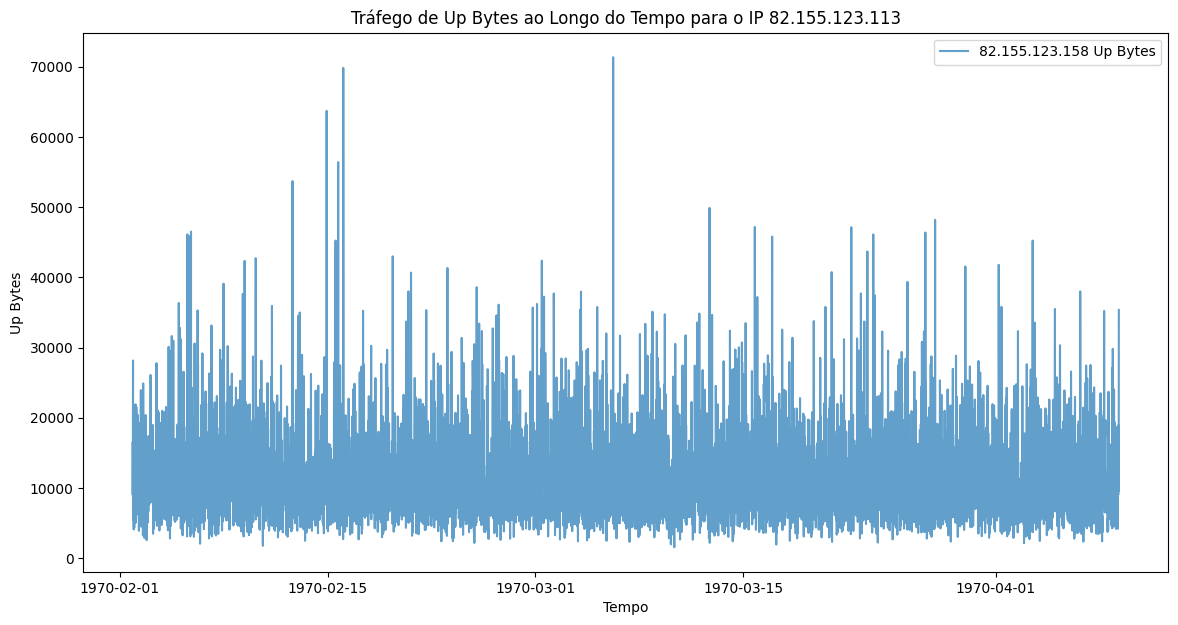

In [60]:
# Filtrar os dados para os IPs específicos
ip_113 = server_df[server_df['src_ip'] == '82.155.123.113']

# Mostrar os maiores valores de up_bytes para o IP
print(ip_113.nlargest(10, 'up_bytes'))

# Plotar o tráfego ao longo do tempo para os IPs específicos
plt.figure(figsize=(14, 7))
plt.plot(ip_113['timestamp'], ip_113['up_bytes'], label='82.155.123.158 Up Bytes', alpha=0.7)
plt.title('Tráfego de Up Bytes ao Longo do Tempo para o IP 82.155.123.113')
plt.xlabel('Tempo')
plt.ylabel('Up Bytes')
plt.legend()
plt.show()

### Regras SIEM Sugeridas

1. **Deteção de Picos Anómalos no Tráfego de Down Bytes**
   - **Regra**: Configurar alertas para quando o tráfego de Down Bytes exceder 400,000 bytes num curto período de tempo.
   - **Justificação**: Picos significativos no tráfego de Down Bytes podem indicar a transferência de grandes quantidades de dados, possivelmente devido a downloads massivos ou sincronizações de dados, o que pode ser um sinal de atividades suspeitas ou não autorizadas.

2. **Deteção de Picos Anómalos no Tráfego de Up Bytes**
   - **Regra**: Configurar alertas para quando o tráfego de Up Bytes exceder 50,000 bytes.
   - **Justificação**: Picos elevados no tráfego de Up Bytes podem indicar a exfiltração de dados ou uploads massivos, o que pode ser uma atividade maliciosa, como o roubo de dados ou a transmissão de informação sensível para fora da rede.

3. **Monitorização de IPs Específicos**
   - **Regra**: Manter um monitoramento constante do IP 82.155.123.113 devido ao seu comportamento anómalo e picos de tráfego.
   - **Justificação**: O IP 82.155.123.113 mostrou padrões de tráfego anómalos, incluindo picos significativos de dados. A monitorização contínua ajuda a identificar atividades incomuns e a responder rapidamente a possíveis incidentes de segurança.

4. **Análise de Padrões de Tráfego com Machine Learning**
   - **Regra**: Implementar algoritmos de machine learning para detectar padrões normais de tráfego e identificar desvios significativos desses padrões.
   - **Justificação**: Utilizar machine learning permite identificar comportamentos anómalos de forma mais precisa, aprendendo continuamente com os dados de tráfego normal e identificando variações suspeitas que possam indicar ameaças de segurança.

5. **Alertas de Alta Frequência de Pacotes**
   - **Regra**: Configurar alertas para atividades de alta frequência, como inúmeros pacotes enviados num curto intervalo de tempo.
   - **Justificação**: Um elevado número de pacotes num curto período pode indicar ataques de negação de serviço (DoS) ou outras atividades maliciosas que tentam sobrecarregar a rede ou comprometer a segurança.